In [1]:
# 0) Install & Imports
# ============================================
!pip install pmdarima

from google.colab import files
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)

In [2]:
import pandas as pd
from google.colab import files

# Upload and read CSV
uploaded = files.upload()
df = pd.read_csv('World_MerchantFleet.csv')

# You now work directly with df, no filtering to 'World' or ship types
# Example: display the first few rows
df.head()

Saving World_MerchantFleet.csv to World_MerchantFleet (1).csv


/tmp/ipython-input-3490693688.py:6: DtypeWarning: Columns (15,18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('World_MerchantFleet.csv')


,Year,Economy,Economy Label,ShipType,ShipType Label,Dead weight tons in thousands,Dead weight tons in thousands Footnote,Dead weight tons in thousands Missing value,Percentage of total world,Percentage of total world Footnote,...,Percentage of total fleet Missing value,Number of ships,Number of ships Footnote,Number of ships Missing value,Gross Tonnage in thousands,Gross Tonnage in thousands Footnote,Gross Tonnage in thousands Missing value,Average age of vessels (years),Average age of vessels (years) Footnote,Average age of vessels (years) Missing value
0,1980,0000,World,0,Total fleet,672192.465,NaN,NaN,100.0,NaN,...,NaN,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected
1,1980,0000,World,1,Oil tankers,337945.534,NaN,NaN,100.0,NaN,...,NaN,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected
2,1980,0000,World,2,Bulk carriers,181880.282,NaN,NaN,100.0,NaN,...,NaN,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected
3,1980,0000,World,3,General cargo,112840.897,NaN,NaN,100.0,NaN,...,NaN,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected
4,1980,0000,World,4,Container ships,10290.114,NaN,NaN,100.0,NaN,...,NaN,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected


In [3]:


# تجهيز نوع السفينة لجميع البيانات
df["ShipType"] = (
    df["ShipType Label"]
      .str.strip()
      .str.lower()
      .replace({
          "total fleet": "Total fleet",
          "oil tankers": "Oil tankers",
          "bulk carriers": "Bulk carriers",
          "general cargo": "General cargo",
          "container ships": "Container ships",
          "other types of ships": "Other types of ships"
      })
)

# حساب الوزن بملايين الأطنان
df["DWT_million"] = df["Dead weight tons in thousands"] / 1000.0

# ما في فلترة – نحتفظ بكل الدول والسنوات
# لمن تحتاج تشتغل على world:
df_world = df[df["Economy Label"] == "World"]


In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Percentage Error
# ---------------------------------------------------------
def percent_error(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    mask = true != 0
    true = true[mask]
    pred = pred[mask]
    return np.mean(np.abs((true - pred) / true)) * 100


# ---------------------------------------------------------
# Manual ARIMA (SARIMAX)
# ---------------------------------------------------------
def manual_arima(train, test, order):

    model = sm.tsa.SARIMAX(
        train,
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # TRAIN prediction (aligned)
    pred_train = model.get_prediction(
        start=train.index[0],
        end=train.index[-1]
    ).predicted_mean

    # TEST forecast (aligned)
    pred_test = model.get_forecast(steps=len(test)).predicted_mean
    pred_test.index = test.index

    # Metrics
    rmse_train = np.sqrt(mean_squared_error(train, pred_train))
    rmse_test  = np.sqrt(mean_squared_error(test,  pred_test))

    pe_train = percent_error(train.values, pred_train.values)
    pe_test  = percent_error(test.values,  pred_test.values)

    return model, rmse_train, rmse_test, pe_train, pe_test, pred_train, pred_test


# ---------------------------------------------------------
# AUTO ARIMA GRID SEARCH (SARIMAX)
# ---------------------------------------------------------
def grid_search_arima(train, test):

    best_rmse = float("inf")
    best = None

    for p in range(0, 6):
        for d in [0, 1]:
            for q in range(0, 6):

                try:
                    model = sm.tsa.SARIMAX(
                        train,
                        order=(p, d, q),
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    ).fit(disp=False)

                    pred_train = model.get_prediction(
                        start=train.index[0],
                        end=train.index[-1]
                    ).predicted_mean

                    pred_test = model.get_forecast(steps=len(test)).predicted_mean
                    pred_test.index = test.index

                    rmse_train = np.sqrt(mean_squared_error(train, pred_train))
                    rmse_test  = np.sqrt(mean_squared_error(test, pred_test))

                    pe_train = percent_error(train.values, pred_train.values)
                    pe_test  = percent_error(test.values, pred_test.values)

                    if rmse_test < best_rmse:
                        best_rmse = rmse_test
                        best = ((p, d, q), model,
                                rmse_train, rmse_test,
                                pe_train, pe_test,
                                pred_train, pred_test)

                except:
                    continue

    return best


# ---------------------------------------------------------
# Plotting Function
# ---------------------------------------------------------
def plot_best_model(ship, train, test, pred_train, pred_test, order):
    plt.figure(figsize=(12,5))

    # Actual
    plt.plot(train.index, train, label="Train (Actual)", linewidth=2)
    plt.plot(test.index, test, label="Test (Actual)", linewidth=2)

    # Predictions
    plt.plot(pred_train.index, pred_train, '--', label="Train Prediction")
    plt.plot(pred_test.index, pred_test, '--', label="Test Forecast")

    plt.title(f"{ship} – ARIMA {order}")
    plt.xlabel("Year")
    plt.ylabel("DWT (million)")
    plt.grid(True)
    plt.legend()
    plt.show()

========= Total fleet ========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


--- MANUAL ARIMA: (7, 0, 5)
RMSE_train: 217.39749238699284
RMSE_test : 54.50557905589989
PE_train  : 13.267140810412576
PE_test   : 1.9976312344550755

--- AUTO ARIMA: (3, 0, 2)
RMSE_train: 143.89293306913396
RMSE_test : 9.489430191519897
PE_train  : 6.304338747517704
PE_test   : 0.37597508607175856

👉 BEST MODEL = AUTO ARIMA (3, 0, 2)


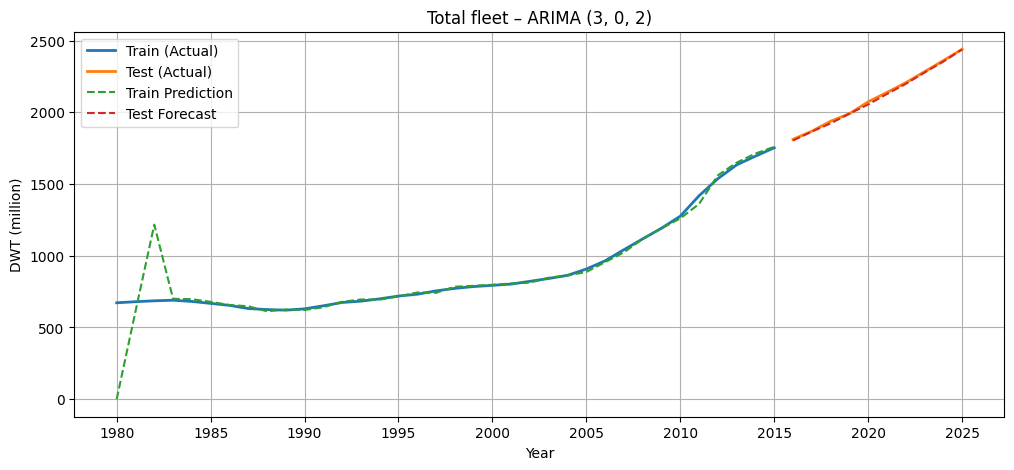

In [6]:
best_orders_dict = {}

ship = "Total fleet"

dship = df_world[df_world["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

# Split
train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]

print("========= Total fleet ========")

# -------------------------------
# MANUAL MODEL
# -------------------------------
manual_order = (7,0,5)

(manual_model,
 rmse_train_m,
 rmse_test_m,
 pe_train_m,
 pe_test_m,
 pred_train_m,
 pred_test_m) = manual_arima(train, test, manual_order)

# -------------------------------
# AUTO MODEL
# -------------------------------
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 pred_train_a,
 pred_test_a) = grid_search_arima(train, test)

# -------------------------------
# SHOW RESULTS
# -------------------------------
print("\n--- MANUAL ARIMA:", manual_order)
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)
print("PE_train  :", pe_train_m)
print("PE_test   :", pe_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)
print("PE_train  :", pe_train_a)
print("PE_test   :", pe_test_a)


# -------------------------------
# SELECT BEST MODEL
# -------------------------------
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_model = auto_model
    best_order = auto_order
    pred_train_best = pred_train_a
    pred_test_best  = pred_test_a
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", manual_order)
    best_model = manual_model
    best_order = manual_order
    pred_train_best = pred_train_m
    pred_test_best  = pred_test_m

best_orders_dict[ship] = best_order

# -------------------------------
# PLOT BEST MODEL
# -------------------------------
plot_best_model(ship, train, test, pred_train_best, pred_test_best, best_order)

========= Oil tankers ========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


--- MANUAL ARIMA: (7, 1, 2)
RMSE_train: 61.797336348809466
RMSE_test : 97.91911994711973
PE_train  : 7.209463637047166
PE_test   : 13.831853278098679

--- AUTO ARIMA: (4, 0, 4)
RMSE_train: 78.73268370233049
RMSE_test : 12.30600399137935
PE_train  : 9.162761034050233
PE_test   : 1.57302677190449

👉 BEST MODEL = AUTO ARIMA (4, 0, 4)


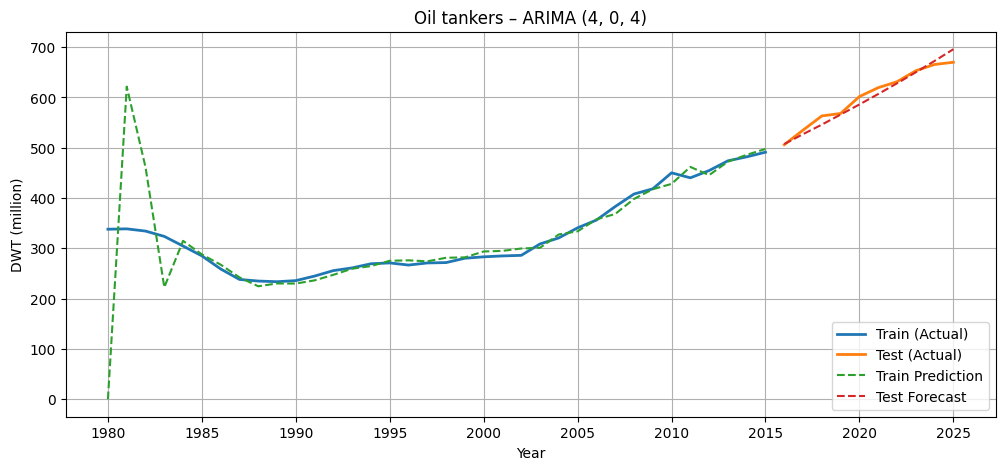

In [8]:
# =========================================================
#              RUNNING FOR ONE SHIP: OIL TANKERS
# =========================================================

ship = "Oil tankers"

# Extract series
dship = df_world[df_world["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

# Train/test split EXACTLY LIKE THE PAPER
train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]

print("========= Oil tankers ========")

# ---------------------------------------------------------
# MANUAL ARIMA
# ---------------------------------------------------------
(manual_model,
 rmse_train_m,
 rmse_test_m,
 pe_train_m,
 pe_test_m,
 manual_pred_train,
 manual_pred_test) = manual_arima(train, test, (7,1,2))


# ---------------------------------------------------------
# AUTO ARIMA
# ---------------------------------------------------------
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 auto_pred_train,
 auto_pred_test) = grid_search_arima(train, test)


# ---------------------------------------------------------
# SHOW RESULTS
# ---------------------------------------------------------
print("\n--- MANUAL ARIMA:", (7,1,2))
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)
print("PE_train  :", pe_train_m)
print("PE_test   :", pe_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)
print("PE_train  :", pe_train_a)
print("PE_test   :", pe_test_a)


# ---------------------------------------------------------
# BEST MODEL SELECTION
# ---------------------------------------------------------
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_pred_train = auto_pred_train
    best_pred_test  = auto_pred_test
    best_order = auto_order
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", (7,1,2))
    best_pred_train = manual_pred_train
    best_pred_test  = manual_pred_test
    best_order = (7,1,2)

best_orders_dict[ship] = best_order


# ---------------------------------------------------------
# PLOT BEST MODEL
# ---------------------------------------------------------
plot_best_model(
    ship,
    train,
    test,
    best_pred_train,
    best_pred_test,
    best_order
)

========= Bulk carriers ========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


--- MANUAL ARIMA: (6, 0, 1)
RMSE_train: 41.73203889067205
RMSE_test : 264.6274156017982
PE_train  : 8.935945508138401
PE_test   : 24.410074017564508

--- AUTO ARIMA: (1, 1, 3)
RMSE_train: 35.22357272968465
RMSE_test : 21.630854122251332
PE_train  : 6.07289947665046
PE_test   : 2.1845967314097736

👉 BEST MODEL = AUTO ARIMA (1, 1, 3)


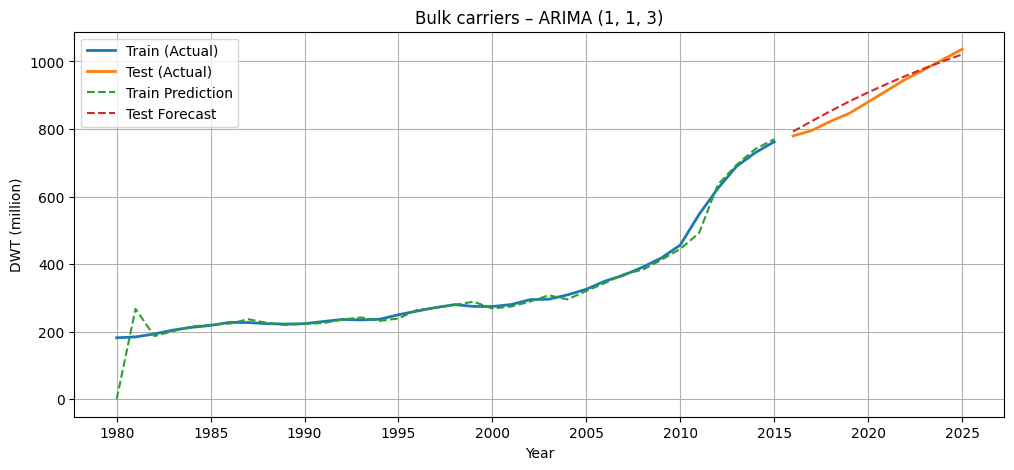

In [10]:
# =========================================================
#              RUNNING FOR ONE SHIP: BULK CARRIERS
# =========================================================

ship = "Bulk carriers"

# Extract series
dship = df_world[df_world["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]

print("========= Bulk carriers ========")

# ---------------------------------------------------------
# MANUAL ARIMA
# ---------------------------------------------------------
manual_order = (6, 0, 1)

(manual_model,
 rmse_train_m,
 rmse_test_m,
 pe_train_m,
 pe_test_m,
 manual_pred_train,
 manual_pred_test) = manual_arima(train, test, manual_order)


# ---------------------------------------------------------
# AUTO ARIMA
# ---------------------------------------------------------
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 auto_pred_train,
 auto_pred_test) = grid_search_arima(train, test)


# ---------------------------------------------------------
# SHOW RESULTS
# ---------------------------------------------------------
print("\n--- MANUAL ARIMA:", manual_order)
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)
print("PE_train  :", pe_train_m)
print("PE_test   :", pe_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)
print("PE_train  :", pe_train_a)
print("PE_test   :", pe_test_a)


# ---------------------------------------------------------
# BEST MODEL SELECTION
# ---------------------------------------------------------
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_pred_train = auto_pred_train
    best_pred_test  = auto_pred_test
    best_order = auto_order
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", manual_order)
    best_pred_train = manual_pred_train
    best_pred_test  = manual_pred_test
    best_order = manual_order

best_orders_dict[ship] = best_order


# ---------------------------------------------------------
# PLOT THE BEST MODEL
# ---------------------------------------------------------
plot_best_model(ship, train, test, best_pred_train, best_pred_test, best_order)

========= General cargo ========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


--- MANUAL ARIMA: (0, 1, 2)
RMSE_train: 19.446977963728305
RMSE_test : 5.666679898921849
PE_train  : 5.660798712623124
PE_test   : 4.735916037512868

--- AUTO ARIMA: (1, 1, 2)
RMSE_train: 20.415594453090158
RMSE_test : 3.49615842431629
PE_train  : 6.688902475413459
PE_test   : 4.124052115307604

👉 BEST MODEL = AUTO ARIMA (1, 1, 2)


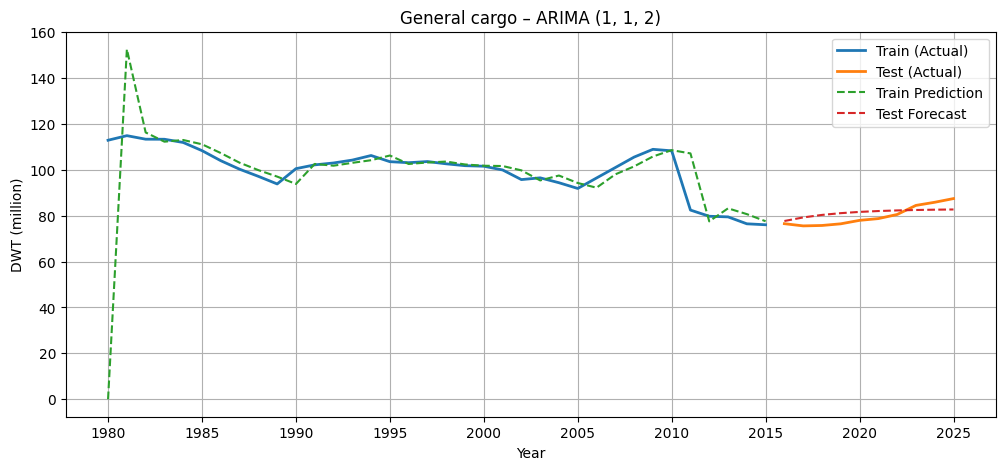

In [11]:
# =========================================================
#              RUNNING FOR ONE SHIP: GENERAL CARGO
# =========================================================

ship = "General cargo"

# Extract series
dship = df_world[df_world["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

# Train/test split
train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]

print("========= General cargo ========")

# ---------------------------------------------------------
# MANUAL ARIMA
# ---------------------------------------------------------
manual_order = (0,1,2)

(manual_model,
 rmse_train_m,
 rmse_test_m,
 pe_train_m,
 pe_test_m,
 manual_pred_train,
 manual_pred_test) = manual_arima(train, test, manual_order)


# ---------------------------------------------------------
# AUTO ARIMA
# ---------------------------------------------------------
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 auto_pred_train,
 auto_pred_test) = grid_search_arima(train, test)



# ---------------------------------------------------------
# SHOW RESULTS
# ---------------------------------------------------------
print("\n--- MANUAL ARIMA:", manual_order)
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)
print("PE_train  :", pe_train_m)
print("PE_test   :", pe_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)
print("PE_train  :", pe_train_a)
print("PE_test   :", pe_test_a)


# ---------------------------------------------------------
# BEST MODEL SELECTION
# ---------------------------------------------------------
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_pred_train = auto_pred_train
    best_pred_test  = auto_pred_test
    best_order = auto_order
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", manual_order)
    best_pred_train = manual_pred_train
    best_pred_test  = manual_pred_test
    best_order = manual_order

best_orders_dict[ship] = best_order


# ---------------------------------------------------------
# PLOT BEST
# ---------------------------------------------------------
plot_best_model(
    ship,
    train,
    test,
    best_pred_train,
    best_pred_test,
    best_order
)


========= Container ships ========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


--- MANUAL ARIMA: (2, 1, 3)
RMSE_train: 3.1109063453032153
RMSE_test : 10.986554768809954
PE_train  : 6.514719085147469
PE_test   : 3.0990151733412676

--- AUTO ARIMA: (5, 1, 4)
RMSE_train: 2.9706066373426823
RMSE_test : 9.603516975670798
PE_train  : 7.181668926957266
PE_test   : 2.8693903599278086

👉 BEST MODEL = AUTO ARIMA (5, 1, 4)


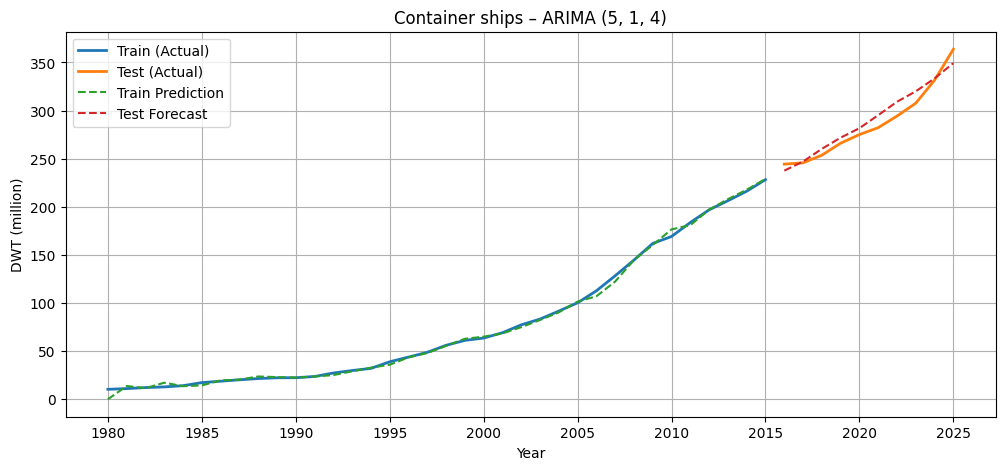

In [12]:
# =========================================================
#                RUN FOR: CONTAINER SHIPS
# =========================================================

ship = "Container ships"

# Extract series
dship = df_world[df_world["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

# Build time series
y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

# Train/Test Split
train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]

print("========= Container ships ========")

# ---------------------------------------------------------
# MANUAL ARIMA
# ---------------------------------------------------------
manual_order = (2, 1, 3)

(manual_model,
 rmse_train_m,
 rmse_test_m,
 pe_train_m,
 pe_test_m,
 manual_pred_train,
 manual_pred_test) = manual_arima(train, test, manual_order)


# ---------------------------------------------------------
# AUTO ARIMA
# ---------------------------------------------------------
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 auto_pred_train,
 auto_pred_test) = grid_search_arima(train, test)


# ---------------------------------------------------------
# PRINT RESULTS
# ---------------------------------------------------------
print("\n--- MANUAL ARIMA:", manual_order)
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)
print("PE_train  :", pe_train_m)
print("PE_test   :", pe_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)
print("PE_train  :", pe_train_a)
print("PE_test   :", pe_test_a)


# ---------------------------------------------------------
# SELECT BEST MODEL
# ---------------------------------------------------------
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_pred_train = auto_pred_train
    best_pred_test  = auto_pred_test
    best_order = auto_order
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", manual_order)
    best_pred_train = manual_pred_train
    best_pred_test  = manual_pred_test
    best_order = manual_order

best_orders_dict[ship] = best_order


# ---------------------------------------------------------
# PLOT BEST MODEL
# ---------------------------------------------------------
plot_best_model(
    ship,
    train,
    test,
    best_pred_train,
    best_pred_test,
    best_order
)

Lengths:
train1: 24  test1: 5
train2: 7  test2: 10

===== PART 1 (Before 2008) =====
RMSE_train1: 3.62395664411291
RMSE_test1 : 15.799969566180325
PE_train1  : 4.824372815674156
PE_test1   : 19.388478304059525

===== PART 2 (After 2008) =====
RMSE_train2: 29.501253397862197
RMSE_test2 : 51.5892313168067
PE_train2  : 8.392295027750961
PE_test2   : 18.162036972812917


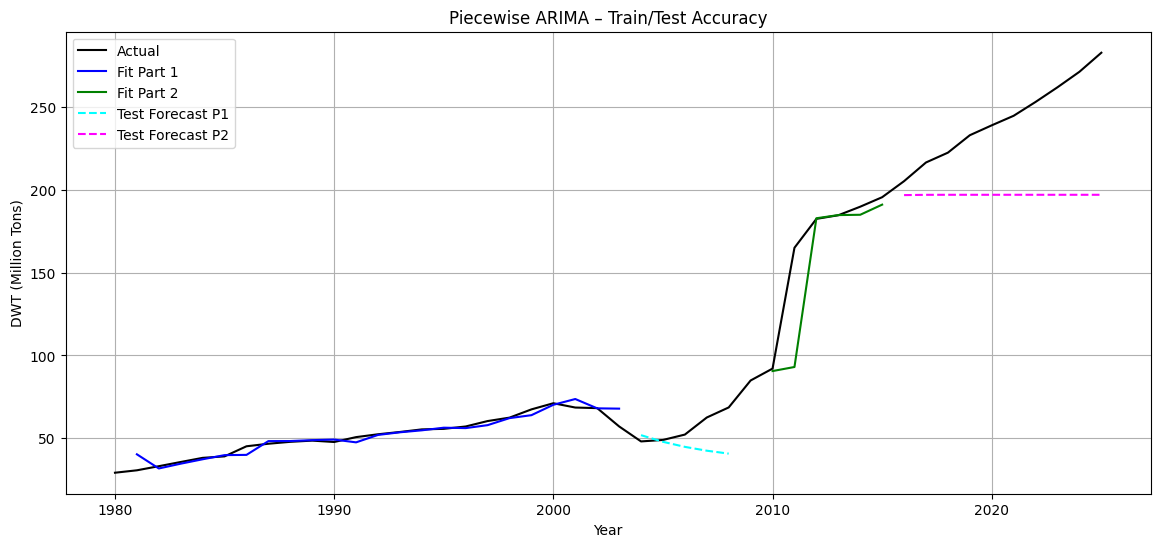

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# ============================================================
#          PIECEWISE ARIMA WITH TRAIN/TEST METRICS
# ============================================================

ship = "Other types of ships"

# Extract full time series
dship = df_world[df_world["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

# ============================================================
#         1) SPLIT INTO TWO REGIMES (before/after 2008)
# ============================================================

# -------- PART 1 --------
train1 = y[(y.index.year <= 2003)]
test1  = y[(y.index.year >= 2004) & (y.index.year <= 2008)]

# -------- PART 2 --------
train2 = y[(y.index.year >= 2009) & (y.index.year <= 2015)]
test2  = y[(y.index.year >= 2016)]

print("Lengths:")
print("train1:", len(train1), " test1:", len(test1))
print("train2:", len(train2), " test2:", len(test2))


# ============================================================
#         2) FIT ARIMA FOR PART 1
# ============================================================

order1 = (1,1,1)

model1 = sm.tsa.SARIMAX(
    train1, order=order1,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

pred_train1 = model1.predict(start=train1.index[1], end=train1.index[-1])
pred_test1  = model1.get_forecast(steps=len(test1)).predicted_mean
pred_test1.index = test1.index

RMSE_train1 = np.sqrt(mean_squared_error(train1.iloc[1:], pred_train1))
RMSE_test1  = np.sqrt(mean_squared_error(test1, pred_test1))

PE_train1 = percent_error(train1.iloc[1:].values, pred_train1.values)
PE_test1  = percent_error(test1.values, pred_test1.values)


# ============================================================
#         3) FIT ARIMA FOR PART 2
# ============================================================

order2 = (1,1,1)

model2 = sm.tsa.SARIMAX(
    train2, order=order2,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

pred_train2 = model2.predict(start=train2.index[1], end=train2.index[-1])
pred_test2  = model2.get_forecast(steps=len(test2)).predicted_mean
pred_test2.index = test2.index

RMSE_train2 = np.sqrt(mean_squared_error(train2.iloc[1:], pred_train2))
RMSE_test2  = np.sqrt(mean_squared_error(test2, pred_test2))

PE_train2 = percent_error(train2.iloc[1:].values, pred_train2.values)
PE_test2  = percent_error(test2.values, pred_test2.values)


# ============================================================
#         PRINT ALL RESULTS
# ============================================================

print("\n===== PART 1 (Before 2008) =====")
print("RMSE_train1:", RMSE_train1)
print("RMSE_test1 :", RMSE_test1)
print("PE_train1  :", PE_train1)
print("PE_test1   :", PE_test1)

print("\n===== PART 2 (After 2008) =====")
print("RMSE_train2:", RMSE_train2)
print("RMSE_test2 :", RMSE_test2)
print("PE_train2  :", PE_train2)
print("PE_test2   :", PE_test2)


# ============================================================
#         4) PLOT THE PIECEWISE FITS
# ============================================================

plt.figure(figsize=(14,6))

plt.plot(y.index.year, y.values, label="Actual", color="black")

plt.plot(pred_train1.index.year, pred_train1.values, label="Fit Part 1", color="blue")
plt.plot(pred_train2.index.year, pred_train2.values, label="Fit Part 2", color="green")

plt.plot(pred_test1.index.year, pred_test1.values, "--", label="Test Forecast P1", color="cyan")
plt.plot(pred_test2.index.year, pred_test2.values, "--", label="Test Forecast P2", color="magenta")

plt.title("Piecewise ARIMA – Train/Test Accuracy")
plt.xlabel("Year")
plt.ylabel("DWT (Million Tons)")
plt.grid(True)
plt.legend()
plt.show()

In [15]:
# ============================================
#   FORECAST ALL SHIPS TO 2035 IN ONE TABLE
# ============================================

forecast_rows = []

ship_list = [
    "Total fleet",
    "Oil tankers",
    "Bulk carriers",
    "General cargo",
    "Container ships",
    "Other types of ships"
]

for ship in ship_list:

    # Extract historical clean series
    dship = dfw[dfw["ShipType"] == ship].sort_values("Year")
    years = dship["Year"].values

    y = pd.Series(
        dship["DWT_million"].values,
        index=pd.to_datetime(years, format="%Y")
    ).asfreq("YS")

    # Train data for general ARIMA models (1980-2015)
    train_general = y[y.index.year <= 2015]

    if ship == "Other types of ships":
        # For 'Other types of ships', use the piecewise ARIMA logic for the second part (after 2008)
        # train2 and order2 were defined in cell Ei30wBhWLUdD
        current_best_order = order2  # (1,1,1)
        # train2 covers 2009-2015 for 'Other types of ships'
        train_ots = y[(y.index.year >= 2009) & (y.index.year <= 2015)]

        print(f"\n=== Forecasting {ship} using Piecewise ARIMA {current_best_order} (Part 2) ===")

        model = sm.tsa.SARIMAX(
            train_ots,
            order=current_best_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        # Forecast from 2016 to 2035 (20 years after 2015)
        steps = 2035 - 2015 # `get_forecast` counts steps *after* the last train point
        forecast_all = model.get_forecast(steps=steps).predicted_mean
        # Manually set index for forecast_all to cover 2016-2035 for direct year lookup
        forecast_all.index = pd.date_range(start=str(train_ots.index[-1].year + 1), periods=steps, freq='YS')

    else:
        # For other ship types, use the best ARIMA order chosen earlier
        current_best_order = tuple(best_orders_dict[ship])

        print(f"\n=== Forecasting {ship} using ARIMA{current_best_order} ===")

        # Fit the model using the general train data (1980-2015)
        model = sm.tsa.SARIMAX(
            train_general,
            order=current_best_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        # Forecast 2016 → 2035
        steps = 2035 - train_general.index[-1].year # Number of years to forecast starting from the year after the last train year
        forecast_all = model.get_forecast(steps=steps).predicted_mean
        # Manually set index for forecast_all to cover 2016-2035 for direct year lookup
        forecast_all.index = pd.date_range(start=str(train_general.index[-1].year + 1), periods=steps, freq='YS')

    # Collect only years 2022 → 2035
    row = {"ShipType": ship, "Best_Order": current_best_order}

    for year_to_forecast in range(2022, 2035 + 1):
        row[f"Forecast_{year_to_forecast}"] = float(forecast_all.loc[str(year_to_forecast)])

    forecast_rows.append(row)

# Final table
forecast_table_2035 = pd.DataFrame(forecast_rows)
forecast_table_2035


=== Forecasting Total fleet using ARIMA(3, 0, 2) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipython-input-2397366447.py:76: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row[f"Forecast_{year_to_forecast}"] = float(forecast_all.loc[str(year_to_forecast)])



=== Forecasting Oil tankers using ARIMA(4, 0, 4) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipython-input-2397366447.py:76: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row[f"Forecast_{year_to_forecast}"] = float(forecast_all.loc[str(year_to_forecast)])
/tmp/ipython-input-2397366447.py:76: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row[f"Forecast_{year_to_forecast}"] = float(forecast_all.loc[str(year_to_forecast)])



=== Forecasting Bulk carriers using ARIMA(1, 1, 3) ===

=== Forecasting General cargo using ARIMA(1, 1, 2) ===


/tmp/ipython-input-2397366447.py:76: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row[f"Forecast_{year_to_forecast}"] = float(forecast_all.loc[str(year_to_forecast)])



=== Forecasting Container ships using ARIMA(5, 1, 4) ===

=== Forecasting Other types of ships using Piecewise ARIMA (1, 1, 1) (Part 2) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipython-input-2397366447.py:76: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row[f"Forecast_{year_to_forecast}"] = float(forecast_all.loc[str(year_to_forecast)])
/tmp/ipython-input-2397366447.py:76: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row[f"Forecast_{year_to_forecast}"] = float(forecast_all.loc[str(year_to_forecast)])


,ShipType,Best_Order,Forecast_2022,Forecast_2023,Forecast_2024,Forecast_2025,Forecast_2026,Forecast_2027,Forecast_2028,Forecast_2029,Forecast_2030,Forecast_2031,Forecast_2032,Forecast_2033,Forecast_2034,Forecast_2035
0,Total fleet,"(3, 0, 2)",2198.239716,2277.060392,2353.701001,2438.257405,2521.381927,2611.952907,2701.806068,2798.750325,2895.657004,2999.396747,3103.748066,3214.759223,3327.004151,3445.810961
1,Oil tankers,"(4, 0, 4)",627.947088,649.881772,672.441187,695.763111,719.832750,744.723164,770.449508,797.059725,824.580123,853.049652,882.499632,912.966737,944.485472,977.093109
2,Bulk carriers,"(1, 1, 3)",957.341623,979.721325,1000.811016,1020.685054,1039.413512,1057.062424,1073.694016,1089.366930,1104.136425,1118.054576,1131.170456,1143.530311,1155.177718,1166.153745
3,General cargo,"(1, 1, 2)",82.259363,82.447107,82.579064,82.671810,82.736997,82.782813,82.815015,82.837649,82.853557,82.864738,82.872597,82.878120,82.882002,82.884731
4,Container ships,"(5, 1, 4)",309.162315,319.978258,333.430414,349.309743,361.871519,375.081379,392.276062,407.223290,420.567299,438.314005,455.912718,470.174332,487.875602,507.908225
5,Other types of ships,"(1, 1, 1)",196.938365,196.938366,196.938366,196.938366,196.938366,196.938366,196.938366,196.938366,196.938366,196.938366,196.938366,196.938366,196.938366,196.938366



============= TOTAL FLEET =============


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


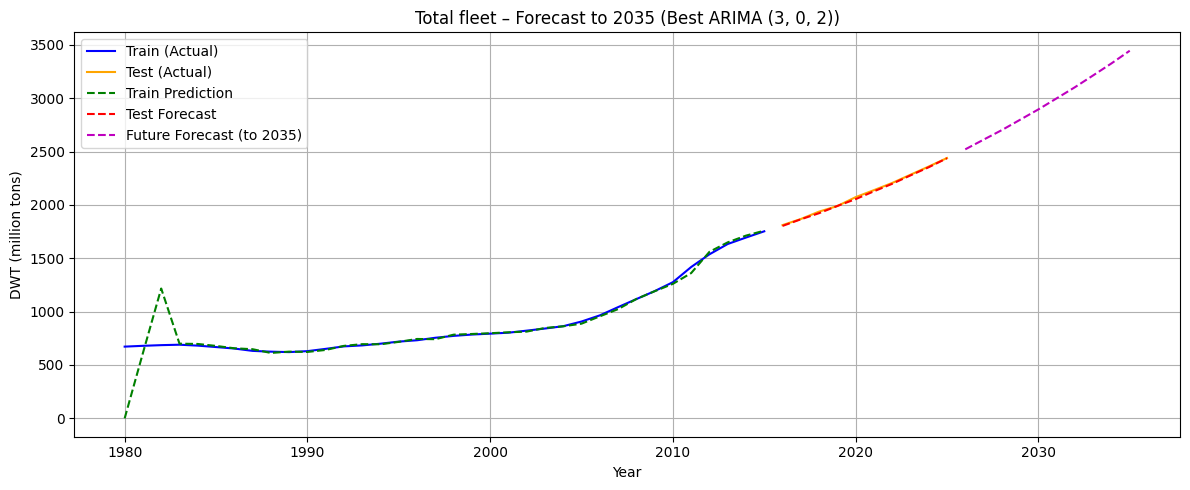


============= OIL TANKERS =============


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


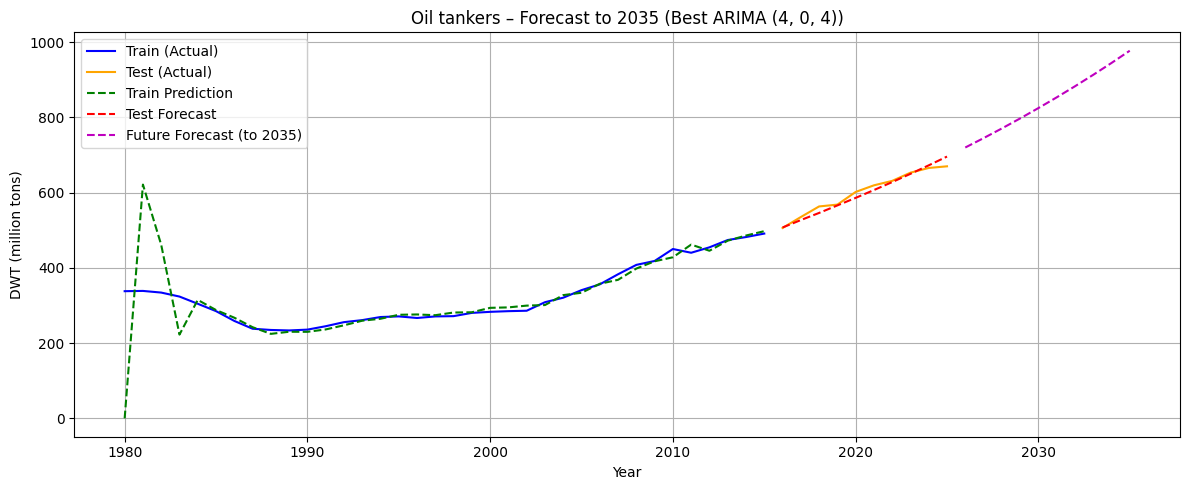


============= BULK CARRIERS =============


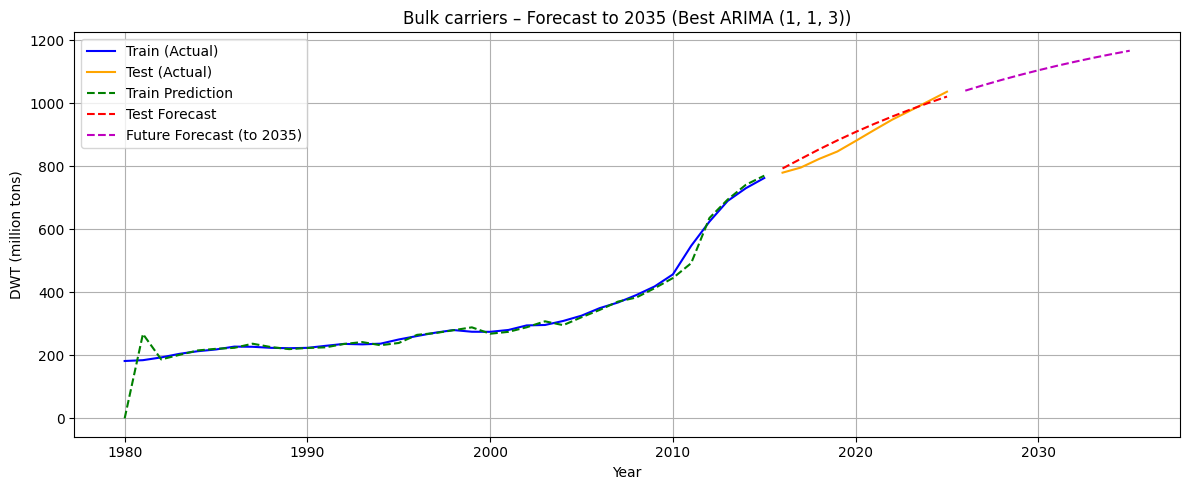


============= GENERAL CARGO =============


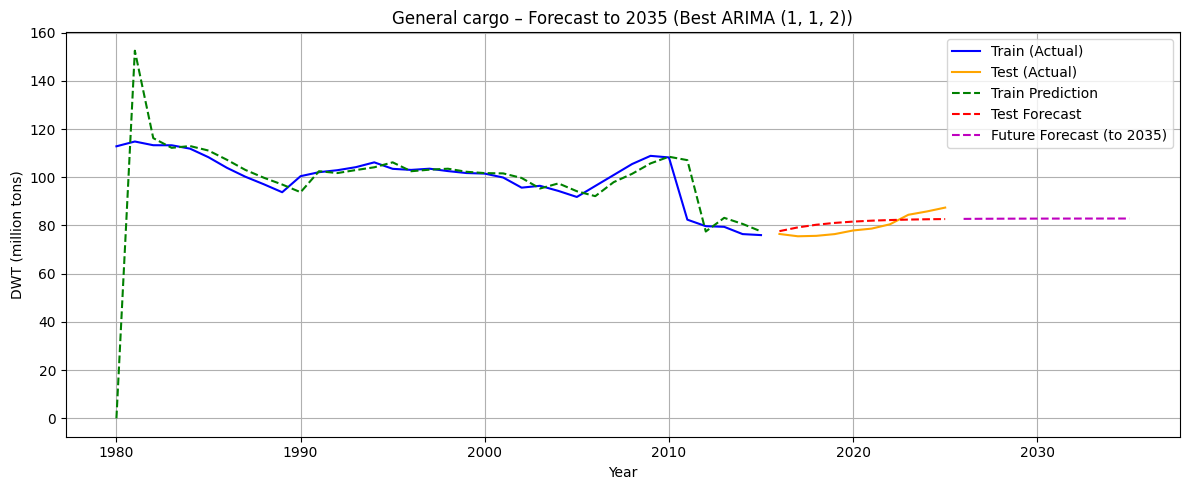


============= CONTAINER SHIPS =============


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


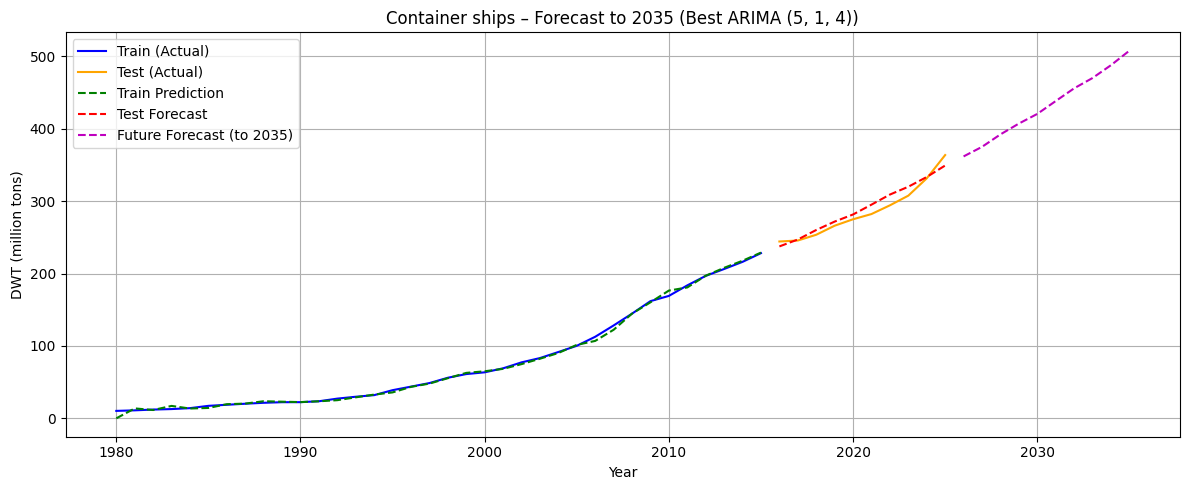


============= OTHER TYPES OF SHIPS =============
No ARIMA model found for Other types of ships. Skipping.


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ============================================================
#          AUTO-PLOT BEST MODEL FOR ALL 6 SHIP TYPES
# ============================================================

ship_list = [
    "Total fleet",
    "Oil tankers",
    "Bulk carriers",
    "General cargo",
    "Container ships",
    "Other types of ships"
]

for ship in ship_list:

    print(f"\n============= {ship.upper()} =============")

    # Extract time series
    dship = dfw[dfw["ShipType"] == ship].sort_values("Year")

    if dship.empty:
        print(f"No data found for {ship}. Skipping.")
        continue

    years = dship["Year"].values

    y = pd.Series(
        dship["DWT_million"].values,
        index=pd.to_datetime(years, format="%Y")
    ).asfreq("YS")

    # Train/test split
    train = y[y.index.year <= 2015]
    test = y[y.index.year >= 2016]

    # Ensure best order exists
    if ship not in best_orders_dict:
        print(f"No ARIMA model found for {ship}. Skipping.")
        continue

    best_order = best_orders_dict[ship]

    # Fit on TRAIN
    model = sm.tsa.SARIMAX(
        train,
        order=best_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # ============================
    #  FORECAST from 2016 → 2035
    # ============================

    forecast_start_year = 2016
    forecast_end_year = 2035
    total_forecast_years = forecast_end_year - forecast_start_year + 1

    forecast_res = model.get_forecast(steps=total_forecast_years)

    fc_mean = forecast_res.predicted_mean

    # Fix forecast index
    forecast_index = pd.date_range(start="2016", periods=total_forecast_years, freq="YS")
    fc_mean.index = forecast_index

    # Split into test and future
    fc_test = fc_mean.iloc[:len(test)]
    fc_future = fc_mean.iloc[len(test):]

    # TRAIN prediction
    pred_train = model.predict(start=train.index[0], end=train.index[-1])

    # ==============================
    #             PLOT
    # ==============================
    plt.figure(figsize=(12, 5))

    # --- Actual Data ---
    plt.plot(train.index.year, train.values, label="Train (Actual)", color="blue")
    if not test.empty:
        plt.plot(test.index.year, test.values, label="Test (Actual)", color="orange")

    # --- Train Prediction ---
    plt.plot(pred_train.index.year, pred_train.values, "--", label="Train Prediction", color="green")

    # --- Test Forecast ---
    if not test.empty:
        plt.plot(test.index.year, fc_test.values, "r--", label="Test Forecast")

    # --- Future Forecast (2016–2035) ---
    plt.plot(fc_future.index.year, fc_future.values, "m--", label="Future Forecast (to 2035)")

    plt.title(f"{ship} – Forecast to 2035 (Best ARIMA {best_order})")
    plt.xlabel("Year")
    plt.ylabel("DWT (million tons)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [15]:
# Filter the main DataFrame to get data for Saudi Arabia
df_saudi = df[df["Economy Label"] == "Saudi Arabia"]

# Now, you can select 'Total fleet' from df_saudi
saudi_fleet = df_saudi[df_saudi["ShipType"] == "Total fleet"]


In [21]:
# هل القيم فعلاً موجودة من 2021 إلى 2025؟
saudi_fleet[saudi_fleet["Year"] >= 2021][["Year", "DWT_million"]]


,Year,DWT_million
55076,2021,13.674756
56714,2022,13.896191
58364,2023,13.405788
60032,2024,14.132433
61706,2025,17.444674


       Year  DWT_million
799    1980     0.178026
2027   1981     0.014679
3238   1982     0.057408
4453   1983     0.545982
5674   1984     0.838191
6903   1985     0.768268
8130   1986     0.660581
9368   1987     0.619209
10609  1988     0.348590
11856  1989     0.309663
13081  1990     0.310000
14314  1991     0.045000
39124  2011     0.000000
40708  2012     0.000000
42286  2013     0.000000
43870  2014     0.081998
45454  2015     0.409284
47044  2016     0.409284
48646  2017     0.409284
50248  2018     0.409284
51850  2019     0.409284
53458  2020     0.409284
55078  2021     0.409284
56716  2022     0.489965
58366  2023     0.731982
60034  2024     0.859106
61708  2025     0.985159


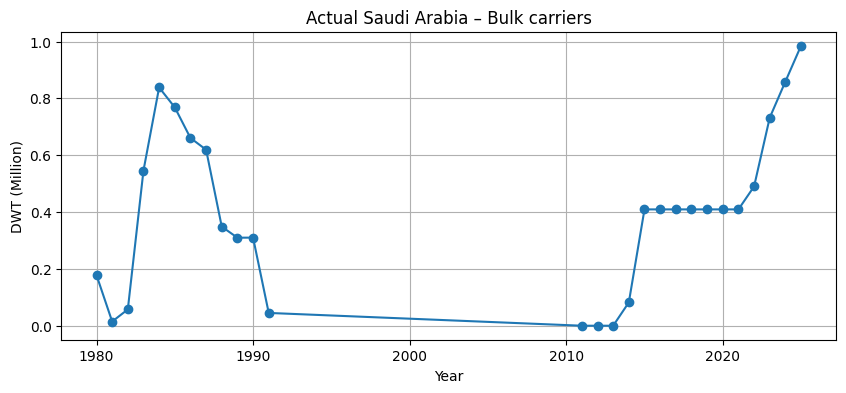

In [25]:
# اختر نوع سفينة معين (مثلاً Bulk carriers)
ship = "Bulk carriers"

# بيانات السعودية لهذا النوع
data = df_saudi[df_saudi["ShipType"] == ship].copy()

# تأكد من الترتيب
data = data.sort_values("Year")

# عارض السلسلة نفسها
print(data[["Year", "DWT_million"]])

# رسم القيم الفعلية فقط بدون forecast
plt.figure(figsize=(10, 4))
plt.plot(data["Year"], data["DWT_million"], marker='o')
plt.title(f"Actual Saudi Arabia – {ship}")
plt.xlabel("Year")
plt.ylabel("DWT (Million)")
plt.grid(True)
plt.show()


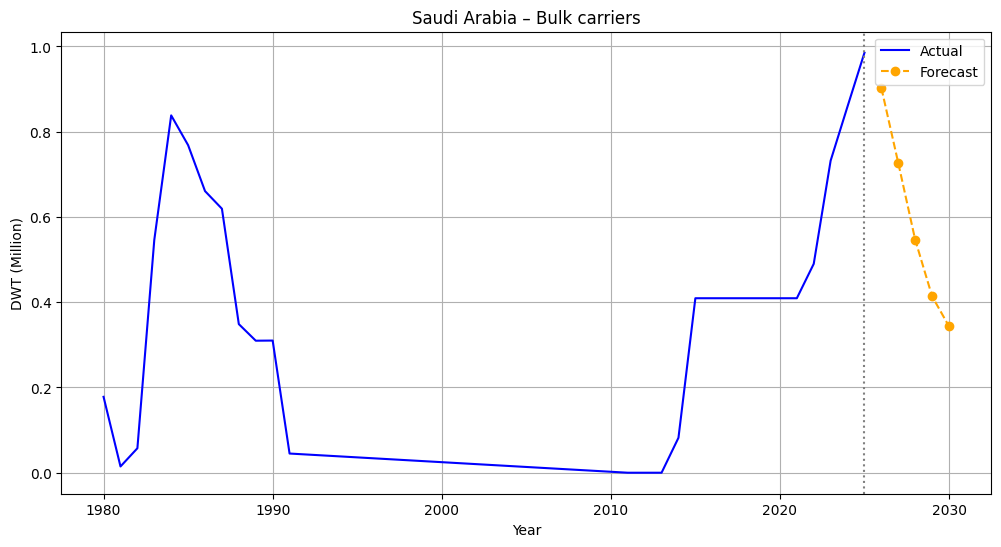

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm

# فلترة بيانات السعودية فقط
df_saudi = df[df["Economy Label"] == "Saudi Arabia"].copy()
df_saudi["Year"] = pd.to_numeric(df_saudi["Year"], errors="coerce")

# اختر نوع السفينة
ship = "Bulk carriers"

# بيانات هذا النوع
data = df_saudi[df_saudi["ShipType"] == ship].copy()
data = data.sort_values("Year")
data = data.dropna(subset=["Year", "DWT_million"])

# تحويل إلى PeriodIndex (سنوي)
series = pd.Series(data["DWT_million"].values, index=pd.PeriodIndex(data["Year"], freq='Y'))

# بناء النموذج
model = pm.auto_arima(series, seasonal=False, stepwise=True, suppress_warnings=True)

# التنبؤ
forecast_horizon = 5
forecast = model.predict(n_periods=forecast_horizon)

# إنشاء مؤشر السنوات المستقبلية بشكل صحيح
last_year = series.index[-1].year
future_years = pd.period_range(start=f"{last_year + 1}", periods=forecast_horizon, freq='Y')
forecast_series = pd.Series(forecast, index=future_years)
actual_years = series.index.to_timestamp()
actual_values = series.values
future_years_ts = future_years.to_timestamp()

# الرسم باستخدام القيم الفعلية والتنبؤ
plt.figure(figsize=(12, 6))

# Actual
plt.plot(
    actual_years,
    actual_values,
    label="Actual",
    color="blue"
)

# Forecast
plt.plot(
    future_years_ts,
    forecast,
    label="Forecast",
    linestyle="--",
    color="orange",
    marker="o"
)

# خط فاصل عند آخر سنة فعلية
plt.axvline(
    x=actual_years.max(),
    color="gray",
    linestyle=":"
)

plt.title("Saudi Arabia – Bulk carriers")
plt.xlabel("Year")
plt.ylabel("DWT (Million)")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
import numpy as np
from sklearn.metrics import mean_squared_error

# -----------------------------
# 1. Train / Test split (Time-based)
# -----------------------------
train_size = int(len(series) * 0.8)

train_series = series.iloc[:train_size]
test_series  = series.iloc[train_size:]

# -----------------------------
# 2. Train ARIMA on TRAIN only
# -----------------------------
model = pm.auto_arima(
    train_series,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True
)

# -----------------------------
# 3. Predictions
# -----------------------------

# 🔹 Train prediction (in-sample)
train_pred = model.predict_in_sample()

# 🔹 Test prediction (out-of-sample)
test_pred = model.predict(n_periods=len(test_series))

# -----------------------------
# 4. Metrics
# -----------------------------

# RMSE
rmse_train = np.sqrt(mean_squared_error(train_series.values, train_pred))
rmse_test  = np.sqrt(mean_squared_error(test_series.values, test_pred))

# PE (%)
pe_train = (
    np.mean(np.abs(train_series.values - train_pred)) /
    np.mean(train_series.values)
) * 100

pe_test = (
    np.mean(np.abs(test_series.values - test_pred)) /
    np.mean(test_series.values)
) * 100

# -----------------------------
# 5. Print results
# -----------------------------
print("📊 ARIMA Metrics – Saudi Arabia | Bulk carriers\n")

print(f"RMSE Train: {rmse_train:.4f}")
print(f"RMSE Test : {rmse_test:.4f}")

print(f"PE Train  : {pe_train:.2f}%")
print(f"PE Test   : {pe_test:.2f}%")

📊 ARIMA Metrics – Saudi Arabia | Bulk carriers

RMSE Train: 0.1402
RMSE Test : 0.3931
PE Train  : 32.92%
PE Test   : 49.53%



🚢 Processing ShipType: Total fleet


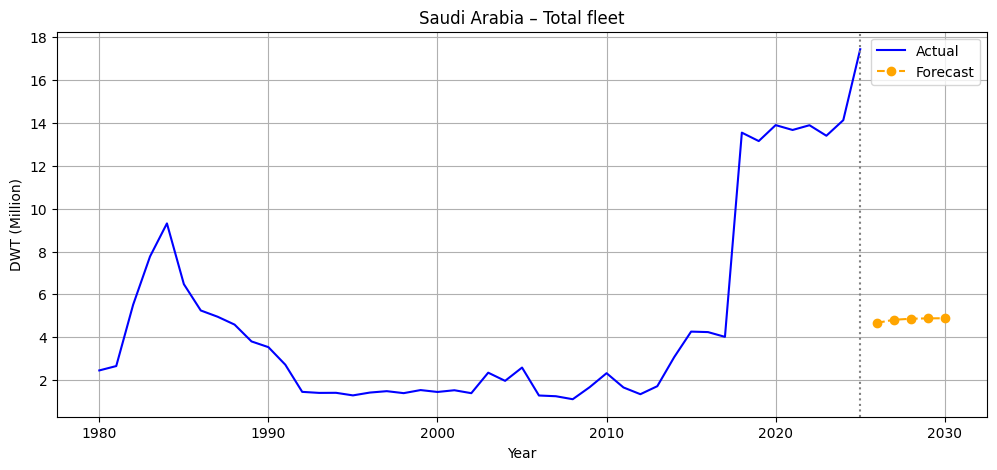


🚢 Processing ShipType: Oil tankers


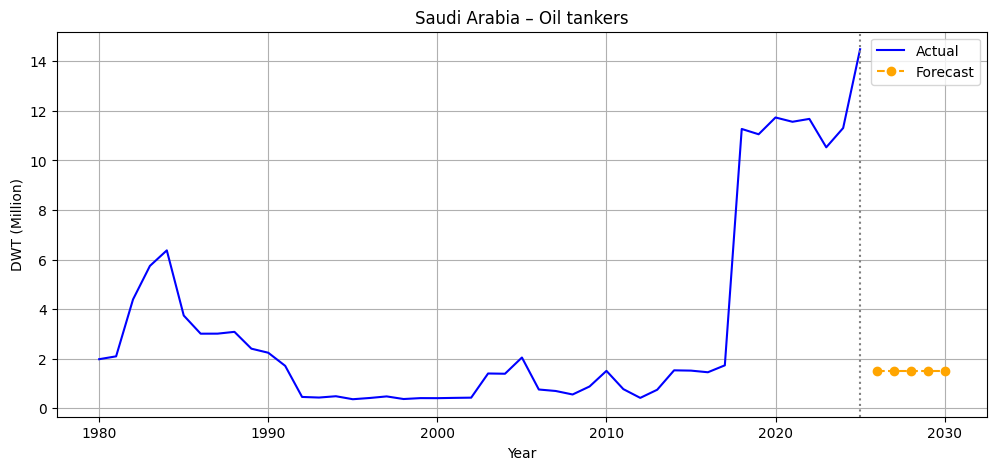


🚢 Processing ShipType: Bulk carriers


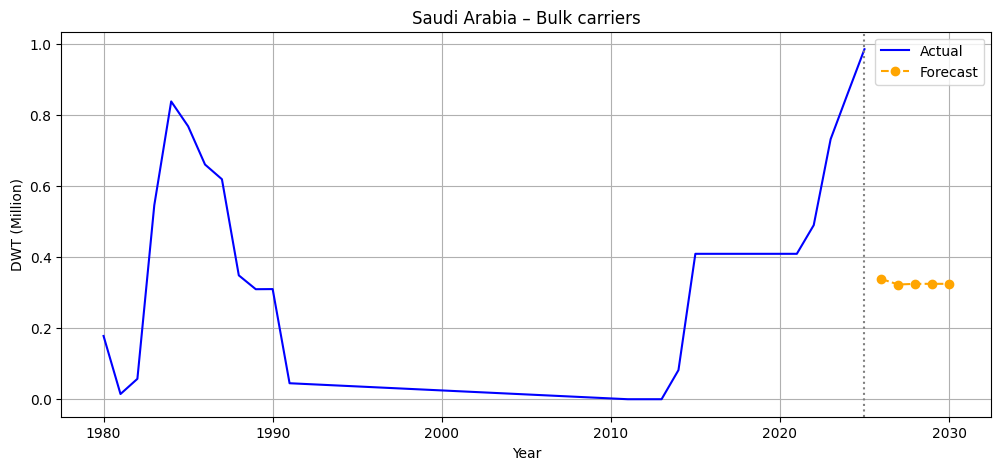


🚢 Processing ShipType: General cargo


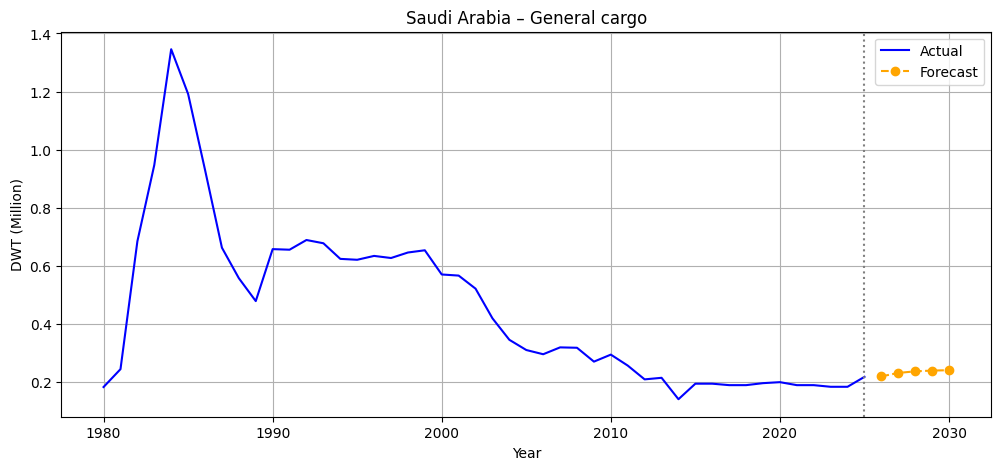


🚢 Processing ShipType: Other types of ships


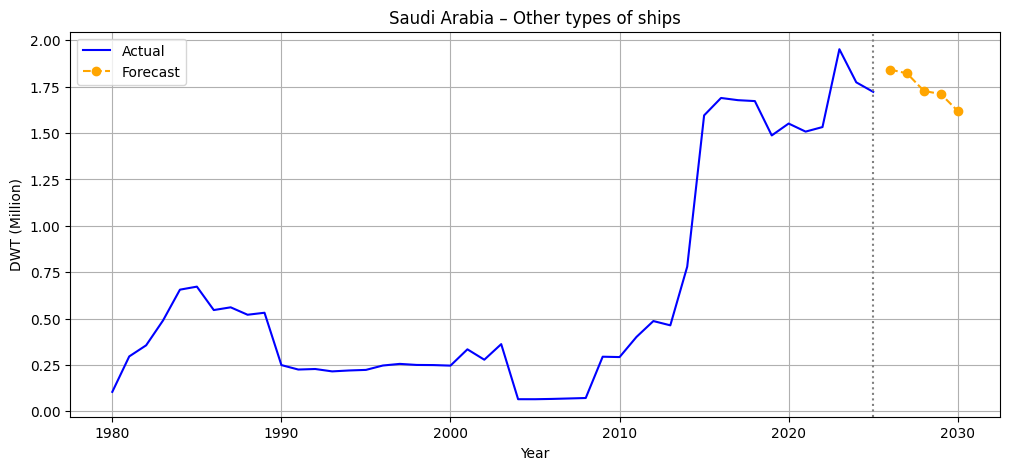


🚢 Processing ShipType: Container ships


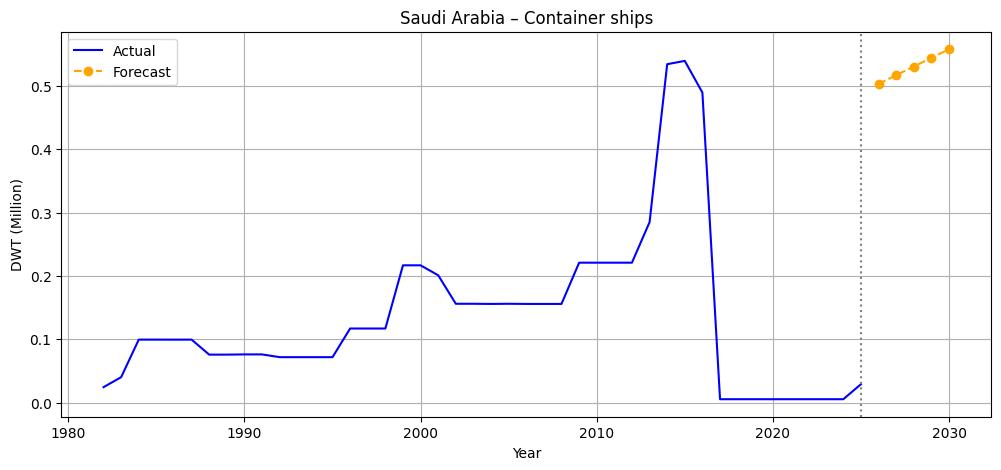

,ShipType,RMSE_Train,RMSE_Test,PE_Train (%),PE_Test (%)
0,Total fleet,1.027143,8.367726,24.002439,62.041764
1,Oil tankers,0.853650,9.163401,32.698016,84.428408
2,Bulk carriers,0.140231,0.393089,32.922989,49.534459
3,General cargo,0.124706,0.045762,15.170361,22.825735
4,Other types of ships,0.158030,0.229312,30.203345,11.212482
5,Container ships,0.049432,0.551262,17.351470,7020.632862


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error

# -----------------------------
# 1. فلترة السعودية
# -----------------------------
df_saudi = df[df["Economy Label"] == "Saudi Arabia"].copy()
df_saudi["Year"] = pd.to_numeric(df_saudi["Year"], errors="coerce")

ship_types = df_saudi["ShipType"].dropna().unique()

results = []

# -----------------------------
# 2. Loop على كل ShipType
# -----------------------------
for ship in ship_types:

    print(f"\n🚢 Processing ShipType: {ship}")

    data = df_saudi[df_saudi["ShipType"] == ship].copy()
    data = data.sort_values("Year")
    data = data.dropna(subset=["Year", "DWT_million"])

    # تجاهل لو البيانات قليلة
    if len(data) < 10:
        print("⚠️ Not enough data – skipped")
        continue

    series = pd.Series(
        data["DWT_million"].values,
        index=pd.PeriodIndex(data["Year"], freq="Y")
    )

    # -------------------------
    # Train / Test split
    # -------------------------
    train_size = int(len(series) * 0.8)
    train_series = series.iloc[:train_size]
    test_series  = series.iloc[train_size:]

    # -------------------------
    # Train ARIMA
    # -------------------------
    try:
        model = pm.auto_arima(
            train_series,
            seasonal=False,
            stepwise=True,
            suppress_warnings=True
        )
    except:
        print("❌ ARIMA failed – skipped")
        continue

    # -------------------------
    # Predictions
    # -------------------------
    train_pred = model.predict_in_sample()
    test_pred = model.predict(n_periods=len(test_series))

    # -------------------------
    # Metrics
    # -------------------------
    rmse_train = np.sqrt(
        mean_squared_error(train_series.values, train_pred)
    )
    rmse_test = np.sqrt(
        mean_squared_error(test_series.values, test_pred)
    )

    pe_train = (
        np.mean(np.abs(train_series.values - train_pred)) /
        np.mean(train_series.values)
    ) * 100

    pe_test = (
        np.mean(np.abs(test_series.values - test_pred)) /
        np.mean(test_series.values)
    ) * 100

    # -------------------------
    # Forecast (future)
    # -------------------------
    forecast_horizon = 5
    forecast = model.predict(n_periods=forecast_horizon)

    last_year = series.index[-1].year
    future_years = pd.period_range(
        start=f"{last_year + 1}",
        periods=forecast_horizon,
        freq="Y"
    )

    # -------------------------
    # Plot
    # -------------------------
    plt.figure(figsize=(12, 5))

    plt.plot(
        series.index.to_timestamp(),
        series.values,
        label="Actual",
        color="blue"
    )

    plt.plot(
        future_years.to_timestamp(),
        forecast,
        label="Forecast",
        linestyle="--",
        color="orange",
        marker="o"
    )

    plt.axvline(
        x=series.index.to_timestamp().max(),
        color="gray",
        linestyle=":"
    )

    plt.title(f"Saudi Arabia – {ship}")
    plt.xlabel("Year")
    plt.ylabel("DWT (Million)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # -------------------------
    # Save results
    # -------------------------
    results.append({
        "ShipType": ship,
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test,
        "PE_Train (%)": pe_train,
        "PE_Test (%)": pe_test
    })

# -----------------------------
# 3. Results table
# -----------------------------
results_df = pd.DataFrame(results)
results_df
